## SewerAI Coding Project

Here's the general strategy for the analysis:
1. First, I'll create a Pandas dataframe to store all image metadata. The dataframe will allow much easier grouping and sub-setting of the data than using only fastai's datablock API. 

2. Second, I'll separate the data into training and test sets for modeling and evaluation. I'll create fastai databunch objects to feed into the model.

3. For comparison purposes, I'll first create a full model which attempts to predict all 12 classes. I'll use a ResNet model as a base, and employ transfer learning from Imagenet weights. 

4. For each defect type, I'll then train a model which classifies that defect vs all others (including no defect). As above, I'll use transfer learning from Imagenet. 

5. To evaluate the video, I'll pass each frame to each of the models created in step 4.

In [1]:
from fastai.vision import *
from sklearn.metrics import f1_score
#Using scikit-video to load the video file
from skvideo.io import vread

### Data Exploration

First I'll take a look at the dataset and find out how many images of each class are available. I'll create a Pandas dataframe to store all the filenames. This will make it easy to take subsets of the data for modeling later. 

In [2]:
path = Path("c:/Datasets/raw_defects")

In [3]:
images = list(path.glob("**/*.png"))
#Total number of images
len(images)

1608

In [4]:
#function to get unique defect id from file path
extract_id = lambda x: re.search(r"_(\d+)\.png",x).group(1)

defect_type = [img.parts[-2] for img in images]
defect_id = [extract_id(img.name) for img in images]
image_df = pd.DataFrame({"filename": ["/".join(img.parts[-2:]) for img in images],"defect_type": defect_type,"defect_id": defect_id})

In [5]:
image_df.head()

,filename,defect_type,defect_id
0,CLEAN/inspection_224_frame_inspection_224_0040...,CLEAN,18446
1,CLEAN/inspection_224_frame_inspection_224_0040...,CLEAN,18446
2,CLEAN/inspection_224_frame_inspection_224_0041...,CLEAN,18446
3,CLEAN/inspection_224_frame_inspection_224_0041...,CLEAN,18446
4,CLEAN/inspection_224_frame_inspection_224_0041...,CLEAN,18446


Get total number of images for each class

In [6]:
image_df["defect_type"].value_counts()

CLEAN    354
DNF      194
DAE      178
TF       162
TS       132
RFJ      132
JOM      124
RMJ       92
FC        90
TB        85
VC        37
JOL       28
Name: defect_type, dtype: int64

Get number of unique defects of each class

In [7]:
image_df.groupby(by="defect_type")["defect_id"].nunique()

defect_type
CLEAN    54
DAE      25
DNF      36
FC       25
JOL       5
JOM      30
RFJ      23
RMJ      13
TB       25
TF       52
TS       32
VC        6
Name: defect_id, dtype: int64

From the above table, we can see that some defect types have relatively little data available. I would expect those classes to be underrepresented in the full model and overfit in their single model. 

### Create dataset

The next step is to create a test dataset to evaluate the models. The test set should not only by composed of unique images, but also unique defect ids. In other words, we should only test on defects the model has never seen before. I am taking 20% of the unique ids for each class as test data, with a minimum of two ids. 

In [35]:
#Set seed for reproducability 
np.random.seed(3432)

#Function to take a list of defect_ids, and return test_pct of them as a list
def get_sample(x,test_pct=0.2):
    valid_idxs = np.random.choice(len(x),max(2,int(len(x)*test_pct)),replace=False)
    return [v for i,v in enumerate(x) if i in valid_idxs]

valid_defects = image_df.groupby(by="defect_type")["defect_id"].unique().apply(get_sample)
#Show test set defect_ids
valid_defects

defect_type
CLEAN    [18456, 18662, 18721, 18170, 18175, 18180, 181...
DAE                         [3664, 3668, 4133, 7125, 7126]
DNF             [1676, 2689, 2691, 4141, 4148, 4161, 4181]
FC                          [9203, 2247, 3197, 5601, 6338]
JOL                                          [14611, 4398]
JOM                 [15088, 15090, 2721, 3112, 3122, 3123]
RFJ                               [1632, 1635, 2383, 2447]
RMJ                                           [1656, 3564]
TB                          [2668, 2855, 3170, 5527, 6180]
TF       [323, 329, 451, 458, 462, 467, 470, 480, 481, ...
TS                 [9260, 15507, 15913, 15915, 2112, 8838]
VC                                            [1661, 1682]
Name: defect_id, dtype: object

In [9]:
#Now create new column "valid", and set it to 1 if the defect_id is in the list created above. 
image_df["valid"] = 0
for defect_type, valid_idxs in valid_defects.items():
    image_df.loc[(image_df["defect_type"] == defect_type) & image_df["defect_id"].isin(valid_idxs),"valid"] = 1

Finally a databunch can be created from the image dataframe. I am scaling images down to 128x128 for this project, as I am on a single GPU with only 8gb memory. I am also using the default fastai transforms, which include horizontal flip, rotate, warp, and brightness change. I am not using flip_vert, since some defects only appear on the top/bottom of pipes. I am also normalizing the data to match ImageNet statistics. 

In [10]:
data_full = (ImageList.from_df(image_df,path,cols="filename")
             .split_from_df(col="valid")
             .label_from_df(cols="defect_type")
             .transform(get_transforms(),size=128)
             #num_workers=0 must be set on windows machine, otherwise a crash occurs. Remove on Linux/OSX.
             .databunch(bs=32,num_workers=0)
             .normalize(imagenet_stats))

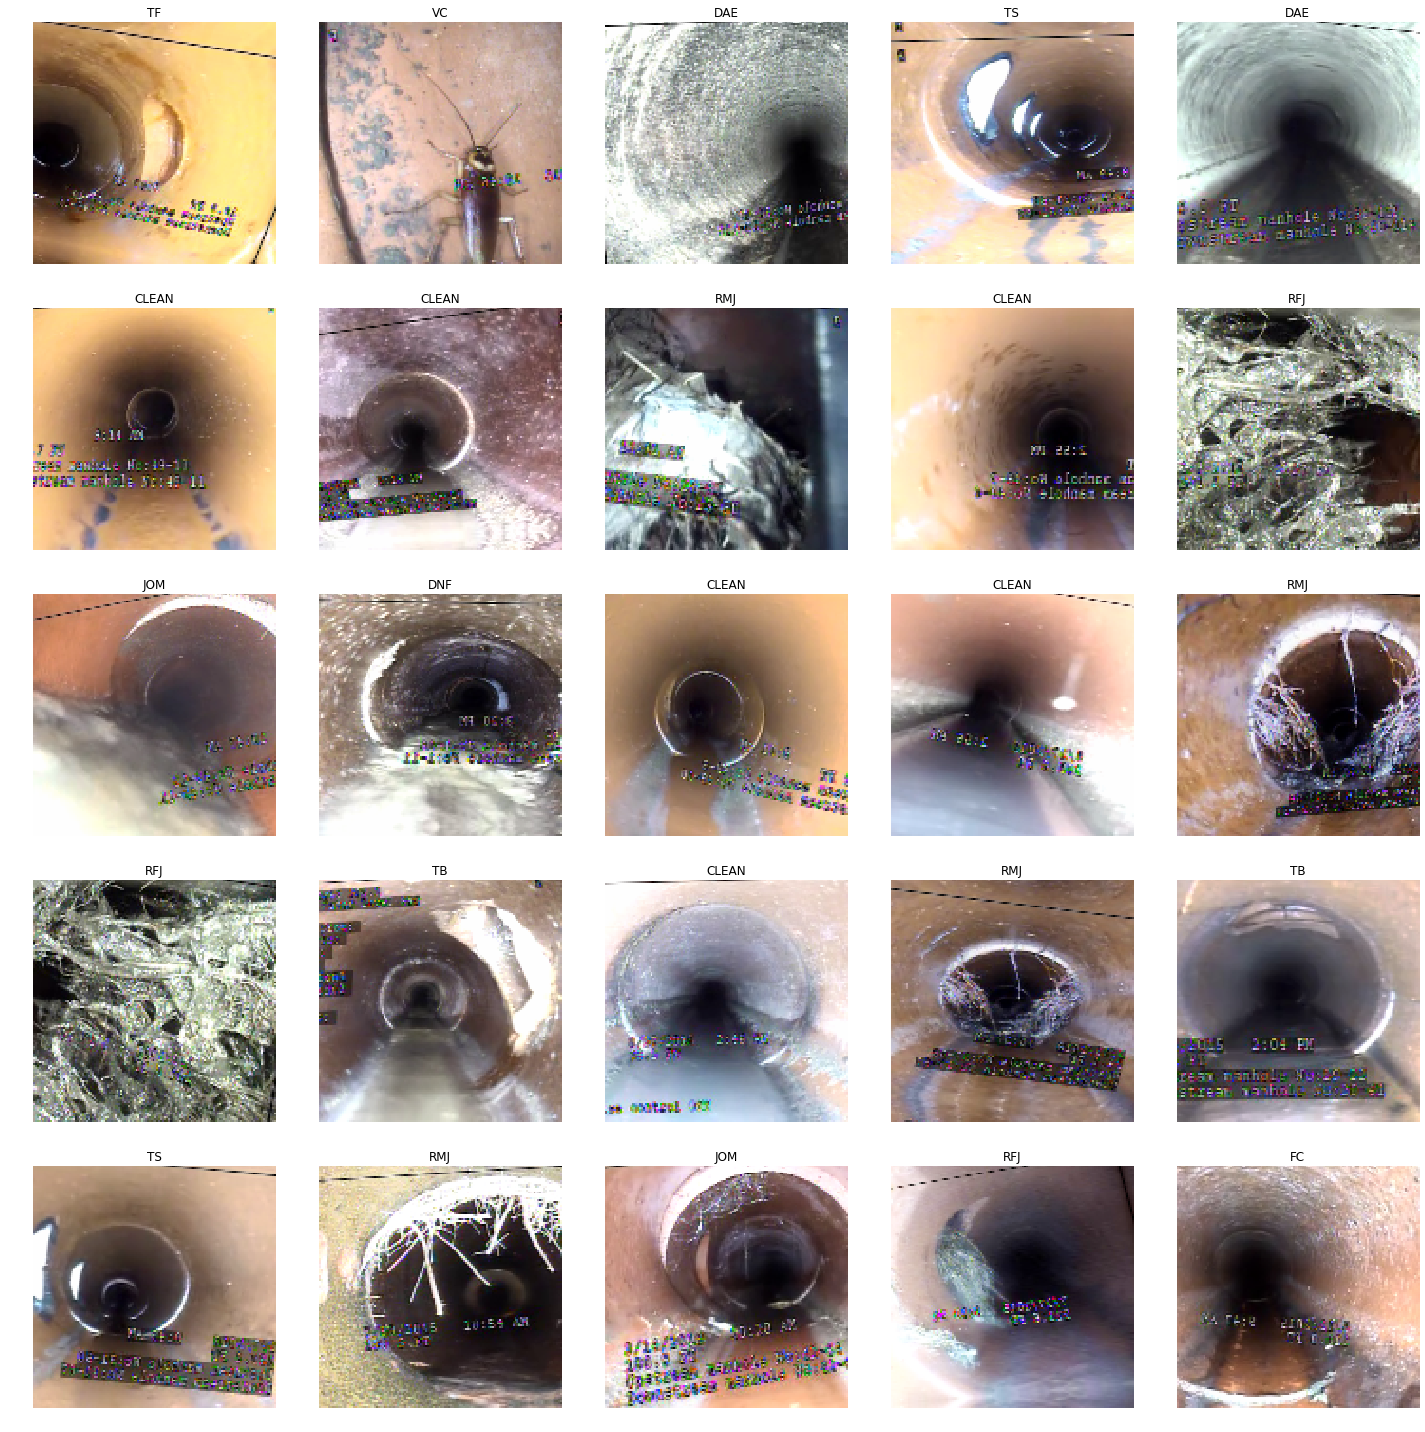

In [11]:
#Show batch of training data to make sure everything is working
data_full.show_batch()

### Modeling

As a first step, I will create a model that attempts to classify all 12 classes at once. This will be used for comparison against the individual class models to be created later. 

I am using a pretrained (on ImageNet) Resnet50 as the model. In addition to accuracy, I am also tracking F1 score, as this will give a better idea of performance for each class -- since the classes are unbalanced in terms of amount of data, accuracy alone may show better performance than is actually being achieved.

The general procedure for using transfer learning is this:

1) Create base model and initialize it with weights learned from training on ImageNet

2) Freeze the model up to the classifier head, and train just that head on the new data at a relatively high learning rate

3) Unfreeze the model, and train the entire network at  a lower learning rate. This can be done in stages if needed

In [12]:
#Create learner with pretrained resnet50 as base
learn_full = cnn_learner(data_full,models.resnet50,metrics=[accuracy,FBeta(beta=1,average="macro")])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


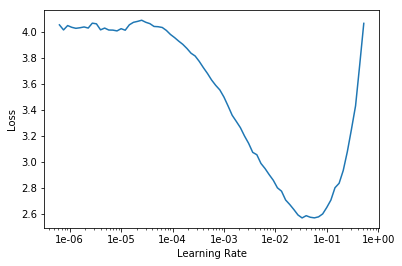

In [13]:
#Find optimal learning rate, going with 3e-3
learn_full.lr_find()
learn_full.recorder.plot()

In [13]:
#Train only fully connected head
learn_full.fit_one_cycle(3,3e-3)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.750569,2.235532,0.591900,0.473450,00:18
1,0.984286,1.909947,0.579439,0.497150,00:12
2,0.645719,1.798813,0.657321,0.567761,00:12


In [14]:
#Unfreeze and train full resnet
learn_full.unfreeze()
learn_full.fit_one_cycle(10,3e-4)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.275083,1.707651,0.691589,0.583958,00:14
1,0.303670,2.073687,0.613707,0.518094,00:15
2,0.416856,1.816248,0.604361,0.522511,00:14
3,0.396531,1.567214,0.672897,0.550595,00:14
4,0.314587,1.417430,0.713396,0.644786,00:14
5,0.242218,1.709138,0.676012,0.584361,00:14
6,0.180446,1.558940,0.713396,0.653212,00:14
7,0.109882,1.399730,0.719626,0.635945,00:14
8,0.072188,1.345699,0.728972,0.642769,00:14
9,0.055100,1.370338,0.732087,0.655821,00:14


The block below prints the class accuracy and f1 score for each defect type. 

In [36]:
preds,targets = learn_full.get_preds(DatasetType.Valid)
results = []
for i,dn in enumerate(data_full.train_ds.y.classes):
    p = torch.argmax(preds,dim=1)[targets==i]
    acc = (p==i).float().mean().item()
    p = torch.where(p==i,torch.ones_like(p),torch.zeros_like(p))
    f1 = f1_score(torch.ones_like(p),p,pos_label=1)
    results.append((dn,acc,f1))
    
full_results_df = pd.DataFrame(results,columns=["defect_type","accuracy_full","f1_full"])
full_results_df

C:\Users\lordn\Anaconda3\envs\fastai\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,defect_type,accuracy_full,f1_full
0,CLEAN,0.892857,0.943396
1,DAE,0.785714,0.880000
2,DNF,0.916667,0.956522
3,FC,0.750000,0.857143
4,JOL,0.272727,0.428571
5,JOM,0.592593,0.744186
6,RFJ,0.555556,0.714286
7,RMJ,1.000000,1.000000
8,TB,0.714286,0.833333
9,TF,0.939394,0.968750


### Single defect models

Finally, we can train a model for each defect class. The function below creates a databunch for each defect class, with its defect labeled as one and all other classes as zero (one vs all model). 

In [37]:
def model_defect_class(defect_type):
    defect_df = image_df.copy()
    defect_df["label"] = (defect_df["defect_type"] == defect_type)
    
    data_defect = (ImageList.from_df(defect_df,path,cols="filename")
                     .split_from_df(col="valid")
                     .label_from_df(cols="label")
                     .transform(get_transforms(),size=128)
                     .databunch(bs=32,num_workers=0)
                     .normalize(imagenet_stats))

    learn_defect = cnn_learner(data_defect,models.resnet50,metrics=[accuracy,FBeta(beta=1,average="binary"),])
    learn_defect.fit_one_cycle(3,3e-3)
    learn_defect.unfreeze()
    learn_defect.fit_one_cycle(10,3e-4)
    return learn_defect.model, learn_defect.recorder.metrics[-1][0].item(),learn_defect.recorder.metrics[-1][1].item()

In [17]:
#Train model for each defect type, storing the model, accuracy, and f1 score. 
model_dict = dict()
results = []
for defect_type in data_full.train_ds.y.classes:
    model, acc, f1 = model_defect_class(defect_type)
    model_dict[defect_type] = model
    results.append((defect_type,acc,f1))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.758524,0.954788,0.766355,0.468085,00:12
1,0.406610,0.312926,0.890966,0.700855,00:12
2,0.298433,0.302654,0.890966,0.695652,00:12


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.168302,0.416508,0.875389,0.600000,00:14
1,0.144675,0.525726,0.878505,0.727273,00:14
2,0.161169,0.698824,0.881620,0.707692,00:14
3,0.150923,0.581431,0.887850,0.653846,00:14
4,0.138108,0.441500,0.890966,0.672897,00:14
5,0.091990,0.373732,0.928349,0.796460,00:14
6,0.067042,0.239402,0.934579,0.796116,00:14
7,0.050547,0.259887,0.943925,0.833333,00:14
8,0.041303,0.329516,0.928349,0.757895,00:14
9,0.033381,0.340023,0.925234,0.744681,00:14


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.806697,0.746700,0.813084,0.516129,00:13
1,0.384701,0.150079,0.947040,0.779221,00:13
2,0.244457,0.165053,0.953271,0.810127,00:13


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.124750,0.222035,0.937695,0.696970,00:14
1,0.093376,0.217100,0.962617,0.842105,00:14
2,0.185891,0.308095,0.934579,0.746988,00:14
3,0.138971,0.239219,0.953271,0.782609,00:14
4,0.185274,0.274345,0.925234,0.600000,00:14
5,0.118090,0.185683,0.962617,0.842105,00:14
6,0.085018,0.161002,0.971963,0.880000,00:14
7,0.066960,0.164351,0.962617,0.833333,00:14
8,0.057749,0.172876,0.965732,0.849315,00:14
9,0.055076,0.168357,0.965732,0.853333,00:14


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.912942,1.832021,0.570093,0.316832,00:12
1,0.490860,0.524064,0.822430,0.504348,00:12
2,0.286460,0.551973,0.872274,0.585859,00:12


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.127858,0.745835,0.828660,0.545455,00:14
1,0.125935,0.519343,0.919003,0.717391,00:14
2,0.183933,0.888475,0.906542,0.500000,00:14
3,0.146244,0.518112,0.897196,0.652632,00:14
4,0.115458,0.546625,0.956386,0.815789,00:14
5,0.093157,0.762751,0.875389,0.444444,00:14
6,0.074037,0.455287,0.940810,0.759494,00:14
7,0.060735,0.633264,0.950156,0.794872,00:14
8,0.043475,0.618566,0.950156,0.794872,00:14
9,0.033701,0.602553,0.953271,0.810127,00:14


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.132654,0.383892,0.816199,0.448598,00:12
1,0.593084,0.244411,0.897196,0.400000,00:12
2,0.333413,0.197325,0.912773,0.416667,00:12


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.166695,0.168963,0.947040,0.653061,00:14
1,0.144506,0.420645,0.878505,0.093023,00:14
2,0.160272,0.264941,0.931464,0.500000,00:14
3,0.135182,0.192560,0.922118,0.358974,00:14
4,0.113675,0.192260,0.903427,0.279070,00:14
5,0.085131,0.145930,0.959502,0.754717,00:14
6,0.073515,0.143364,0.962617,0.777778,00:14
7,0.056737,0.182352,0.928349,0.439024,00:14
8,0.040061,0.165559,0.925234,0.428571,00:14
9,0.035106,0.189158,0.925234,0.428571,00:14


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.030821,0.858722,0.691589,0.168067,00:12
1,0.531204,0.221443,0.937695,0.000000,00:12
2,0.290808,0.173854,0.965732,0.000000,00:12


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.115650,0.158718,0.968847,0.166667,00:14
1,0.108522,0.139913,0.953271,0.117647,00:14
2,0.090973,0.128822,0.968847,0.166667,00:14
3,0.071193,0.153369,0.962617,0.000000,00:14
4,0.048665,0.077397,0.975078,0.428571,00:14
5,0.033983,0.080482,0.981308,0.625000,00:14
6,0.037699,0.047404,0.971963,0.307692,00:14
7,0.029094,0.049547,0.984424,0.705882,00:14
8,0.027907,0.052558,0.984424,0.705882,00:14
9,0.021554,0.053077,0.984424,0.705882,00:14


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.080994,0.691990,0.735202,0.247788,00:12
1,0.596417,0.344588,0.890966,0.222222,00:12
2,0.324618,0.270628,0.928349,0.488889,00:12


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.135797,0.197197,0.950156,0.666667,00:14
1,0.155733,0.234834,0.922118,0.545455,00:14
2,0.169176,0.223521,0.931464,0.476190,00:14
3,0.132993,0.301263,0.909657,0.000000,00:14
4,0.103156,0.306962,0.915888,0.000000,00:14
5,0.078558,0.182850,0.950156,0.600000,00:14
6,0.064576,0.162392,0.959502,0.697674,00:14
7,0.044547,0.235342,0.915888,0.068966,00:14
8,0.036738,0.177041,0.950156,0.600000,00:14
9,0.032966,0.180217,0.950156,0.600000,00:14


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.989231,0.990423,0.676012,0.223881,00:12
1,0.534496,0.291538,0.869159,0.322581,00:12
2,0.296432,0.270823,0.903427,0.340426,00:12


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.122158,0.327887,0.869159,0.382353,00:14
1,0.107941,0.378665,0.903427,0.456140,00:14
2,0.178473,0.327986,0.887850,0.357143,00:14
3,0.140363,1.127254,0.850467,0.351351,00:14
4,0.112908,0.164370,0.956386,0.631579,00:14
5,0.093380,0.190441,0.922118,0.418605,00:14
6,0.071176,0.151429,0.943925,0.400000,00:14
7,0.050625,0.197893,0.934579,0.533333,00:14
8,0.035250,0.235766,0.915888,0.372093,00:14
9,0.028773,0.226391,0.919003,0.409091,00:14


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.015253,0.469195,0.813084,0.268293,00:12
1,0.537892,0.125048,0.962617,0.647059,00:12
2,0.301727,0.035830,1.000000,1.000000,00:12


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.111167,0.069073,0.987539,0.846154,00:14
1,0.101656,1.303644,0.831776,0.289474,00:13
2,0.125070,0.047636,0.996885,0.956522,00:14
3,0.090505,0.043415,1.000000,1.000000,00:14
4,0.073632,0.008706,1.000000,1.000000,00:14
5,0.051817,0.008402,1.000000,1.000000,00:14
6,0.035921,0.005657,1.000000,1.000000,00:14
7,0.025036,0.003186,1.000000,1.000000,00:14
8,0.021505,0.007958,0.996885,0.952381,00:14
9,0.017242,0.007669,0.996885,0.952381,00:14


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.210251,0.663282,0.741433,0.194175,00:12
1,0.628204,0.219691,0.922118,0.358974,00:12
2,0.362661,0.175791,0.959502,0.480000,00:12


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.136519,0.174709,0.940810,0.387097,00:14
1,0.153628,0.231081,0.909657,0.431373,00:14
2,0.152838,0.099531,0.971963,0.689655,00:14
3,0.126839,0.118696,0.959502,0.133333,00:14
4,0.099344,0.141237,0.959502,0.315789,00:14
5,0.075898,0.097702,0.975078,0.600000,00:14
6,0.059256,0.063068,0.975078,0.692308,00:14
7,0.055934,0.079874,0.981308,0.727273,00:14
8,0.043297,0.091697,0.975078,0.600000,00:14
9,0.030144,0.080238,0.975078,0.600000,00:14


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.957283,1.196420,0.607477,0.343750,00:12
1,0.532507,0.146838,0.950156,0.804878,00:12
2,0.314683,0.139662,0.965732,0.857143,00:12


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.170423,0.124128,0.965732,0.857143,00:14
1,0.157070,0.077845,0.981308,0.914286,00:14
2,0.197022,0.368213,0.965732,0.857143,00:14
3,0.187006,0.084600,0.971963,0.880000,00:14
4,0.180928,0.109298,0.947040,0.653061,00:14
5,0.154182,0.030406,0.993769,0.968750,00:14
6,0.128453,0.039373,0.987539,0.939394,00:14
7,0.096334,0.034247,0.993769,0.969697,00:14
8,0.077084,0.032446,0.990654,0.953846,00:14
9,0.052185,0.046686,0.984424,0.927536,00:14


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.007568,0.622659,0.738318,0.275862,00:12
1,0.540005,0.203331,0.947040,0.638298,00:12
2,0.316939,0.222673,0.947040,0.638298,00:12


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.119864,0.225616,0.959502,0.697674,00:14
1,0.127913,0.558324,0.862928,0.405405,00:14
2,0.146501,0.137557,0.962617,0.714286,00:14
3,0.117798,0.169557,0.962617,0.714286,00:14
4,0.102625,0.158622,0.959502,0.711111,00:14
5,0.069618,0.198672,0.965732,0.744186,00:14
6,0.055161,0.147222,0.965732,0.744186,00:14
7,0.043581,0.174797,0.962617,0.714286,00:14
8,0.034273,0.170980,0.965732,0.744186,00:14
9,0.034131,0.175449,0.965732,0.744186,00:14


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.121138,0.444008,0.809969,0.000000,00:13
1,0.546553,0.283525,0.934579,0.000000,00:12
2,0.289390,0.273315,0.943925,0.000000,00:13


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.099739,0.248397,0.940810,0.000000,00:14
1,0.103916,0.250234,0.934579,0.000000,00:14
2,0.087148,0.204142,0.943925,0.000000,00:14
3,0.073991,0.215032,0.943925,0.000000,00:14
4,0.052670,0.265667,0.943925,0.000000,00:14
5,0.035596,0.272810,0.943925,0.000000,00:14
6,0.030345,0.255322,0.943925,0.000000,00:14
7,0.023995,0.296755,0.943925,0.000000,00:14
8,0.019943,0.285901,0.943925,0.000000,00:14
9,0.018661,0.286987,0.943925,0.000000,00:14


### Results

The table below shows the results for each defect type for both the full and single models. 

In [18]:
defect_results_df = pd.DataFrame(results,columns=["defect_type","acc_single","f1_single"])
pd.merge(full_results_df,defect_results_df,on="defect_type")

,defect_type,accuracy_full,f1_full,acc_single,f1_single
0,CLEAN,0.892857,0.943396,0.925234,0.744681
1,DAE,0.785714,0.880000,0.965732,0.853333
2,DNF,0.916667,0.956522,0.953271,0.810127
3,FC,0.750000,0.857143,0.925234,0.428571
4,JOL,0.272727,0.428571,0.984424,0.705882
5,JOM,0.592593,0.744186,0.950156,0.600000
6,RFJ,0.555556,0.714286,0.919003,0.409091
7,RMJ,1.000000,1.000000,0.996885,0.952381
8,TB,0.714286,0.833333,0.975078,0.600000
9,TF,0.939394,0.968750,0.984424,0.927536


As can be seen, going from the full model to the individual defect models improves individual defect accuracy in almost every case. However, this comes at the cost of a drop in F1 score, often a significant one. This indicates that the single models are indeed overfitting to their assigned defect. 

However, given that it is far more important to avoid false negatives than false positives, this may not be a large problem.

### Video

Fastai doesn't have native video support, so there are two options to analyze the video. First is to write an image to disk for each frame. The second is to just load the entire video into a numpy array and create a databunch from that. I'm going with option 2.

In [19]:
video = vread(str(path/"video_sample_692.mp4"))
video = video.transpose(0,3,1,2)
video.shape

(24438, 3, 240, 360)

I'll need a custom `ImageList` class to take rows from the numpy array and load it into a fastai `Image` class. This allows all the usual data augmentation and transform machinery to work. 

In [20]:
class ArrayImageList(ImageList):
    @classmethod
    def from_numpy(cls, numpy_array):
        return cls(items=range(len(numpy_array)),inner_df=numpy_array)
    
    def label_from_array(self, array, label_cls=None, **kwargs):
        return self._label_from_list(array[self.items.astype(np.int)],label_cls=label_cls,**kwargs)
    
    def get(self, i):
        n = self.inner_df[i]
        n = torch.tensor(n).float() / 255
        return Image(n)

In [21]:
data_video = (ArrayImageList.from_numpy(video)
              .split_none()
              .label_const()
              #No transforms, since we are just using the db for evaluation
              .transform(size=128)
              .databunch(bs=32,num_workers=0)
              .normalize(imagenet_stats))

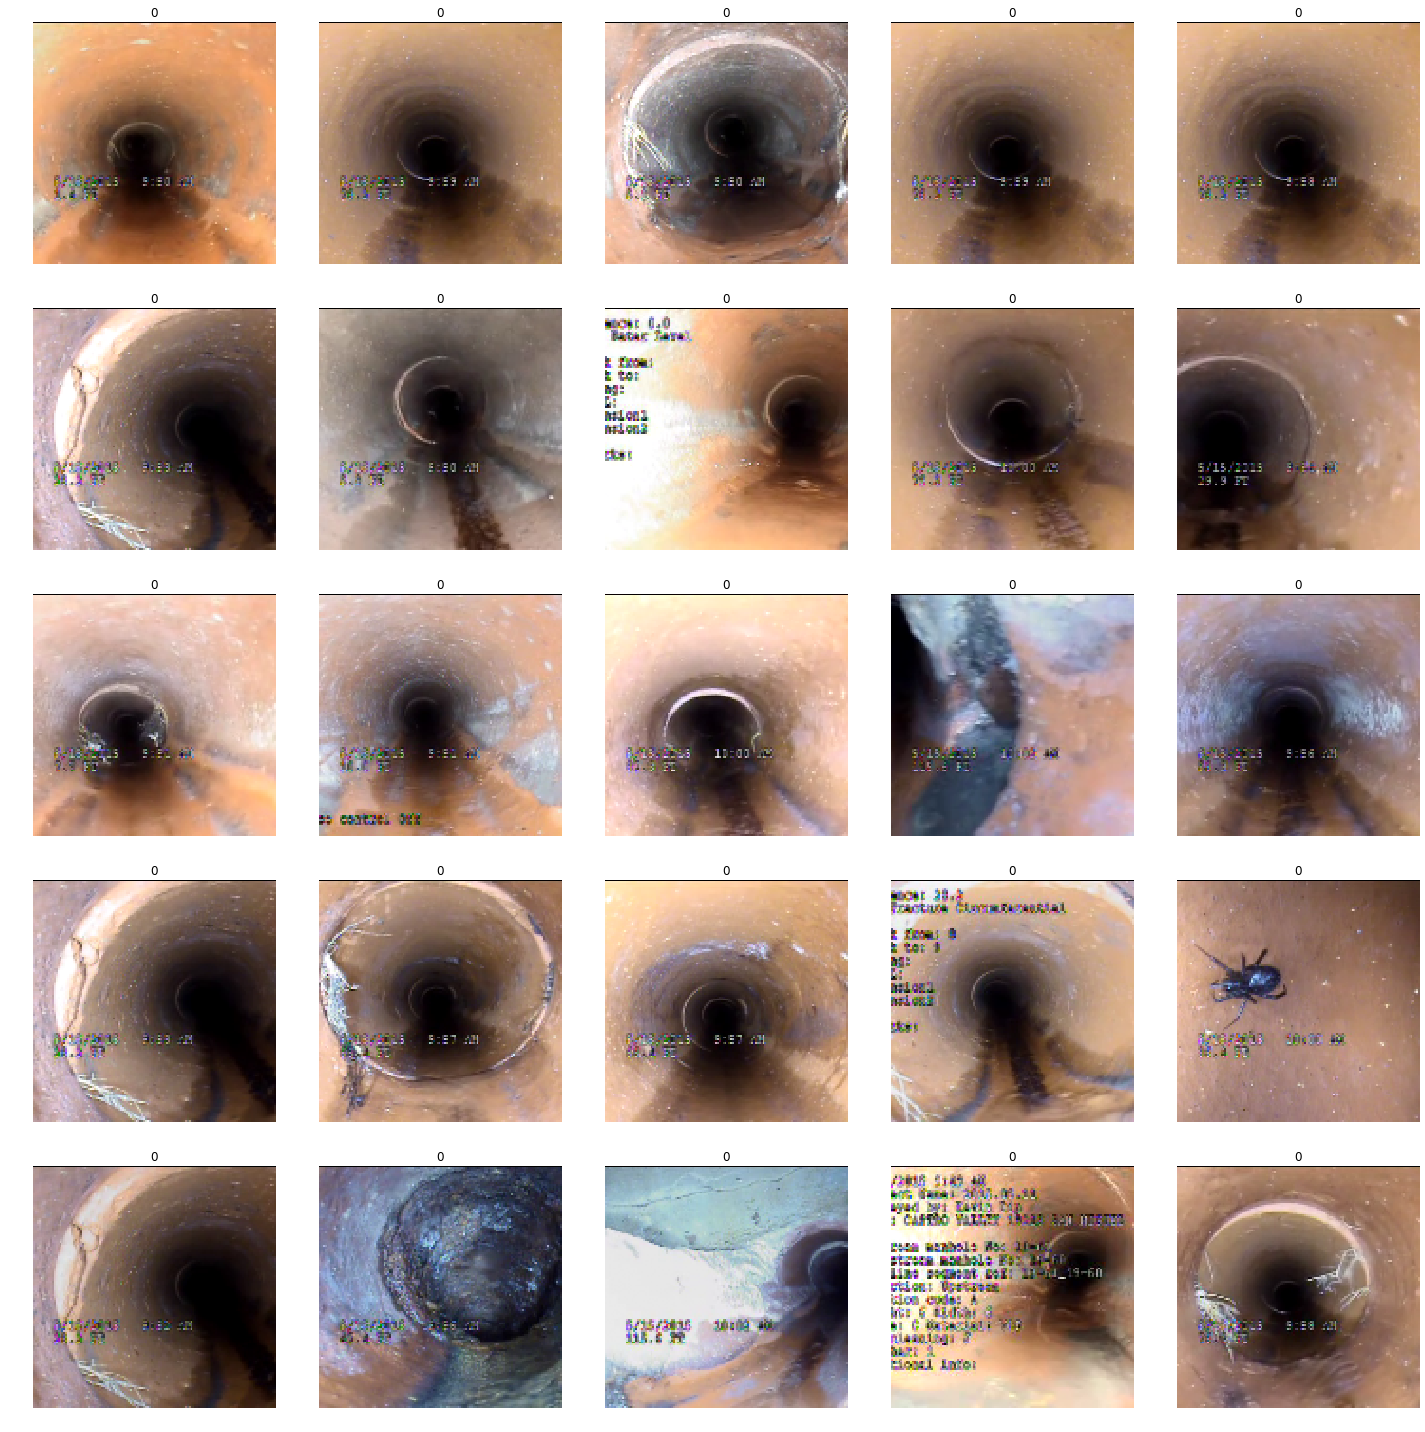

In [22]:
data_video.show_batch()

Now that the video is in a databunch, we can simply call the models on each frame. The output will be a dataframe where each row is a frame and each column is a model. 

In [27]:
result_dict = collections.defaultdict(list)
for frames,_ in progress_bar(data_video.train_dl.new(shuffle=False,drop_last=False)):
    for k,m in model_dict.items():
        preds = m(frames)
        preds = torch.argmax(preds,dim=1)
        result_dict[k].append(preds.detach().cpu())

In [28]:
for key in result_dict.keys():
    result_dict[key] = torch.cat(result_dict[key])

In [30]:
video_df = pd.DataFrame(result_dict)
video_df.head()

,CLEAN,DAE,DNF,FC,JOL,JOM,RFJ,RMJ,TB,TF,TS,VC
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0


## Alternate Approach

I think a good approach to this problem may come from a 2015 Geoffry Hinton paper called [Distilling the Knowledge in a Neural Network](https://arxiv.org/pdf/1503.02531v1.pdf). Here are the main ideas from the paper:

1) Training an ensemble of models is often preferable to a single model. However, specialist models have a tendency to overfit.

2) A model can be used to 'teach' or 'distill into' another model, by requiring that the learning model produce softmax output that matches the output of the teacher. This is preferable to one hot encoded labels, as the softmax distribution contains more information than just the correct class.

3) This approach can then be used to train an ensemble of specialists. First, a generalist model is trained on all the classes. Then, the classes are broken down into groups; the paper does this by grouping easily confused classes. Each specialist is initialized with the weights of the general model and trained on a particular class grouping. When training, half the data comes from the specialist's group, and the other half from the remaining training set. The specialist has an extra 'distilling' loss term to match its output to the generalist's. This reduces the tendency of the specialist to overfit. 

I already trained a general model above. Now, to pick specialist groupings, I'll use the confusion matrix from that model.

In [38]:
ci = learn_full.interpret()

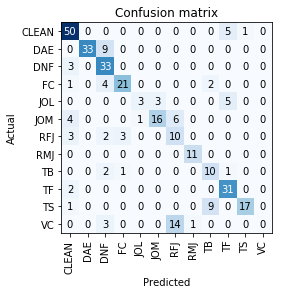

In [39]:
ci.plot_confusion_matrix()

In [40]:
ci.most_confused()

[('VC', 'RFJ', 14),
 ('DAE', 'DNF', 9),
 ('TS', 'TB', 9),
 ('JOM', 'RFJ', 6),
 ('CLEAN', 'TF', 5),
 ('JOL', 'TF', 5),
 ('FC', 'DNF', 4),
 ('JOM', 'CLEAN', 4),
 ('DNF', 'CLEAN', 3),
 ('JOL', 'JOM', 3),
 ('RFJ', 'CLEAN', 3),
 ('RFJ', 'FC', 3),
 ('VC', 'DNF', 3),
 ('FC', 'TB', 2),
 ('RFJ', 'DNF', 2),
 ('TB', 'DNF', 2),
 ('TF', 'CLEAN', 2),
 ('CLEAN', 'TS', 1),
 ('FC', 'CLEAN', 1),
 ('JOM', 'JOL', 1),
 ('TB', 'FC', 1),
 ('TB', 'TF', 1),
 ('TS', 'CLEAN', 1),
 ('VC', 'RMJ', 1)]

In [44]:
class DistillTrainer(LearnerCallback):
    def __init__(self, learn, gen_model, gen_data):
        super().__init__(learn)
        self.gen_model = gen_model
        self.gen_data = gen_data
        self.gen_iter = iter(self.gen_data.train_dl)
        
    def on_batch_begin(self, train, last_input, last_target, **kwargs):
        if not train: return
        
        try:
            gen_batch,y = next(self.gen_iter)
        except:
            self.gen_iter = iter(self.gen_data.train_dl)
            gen_batch,y = next(self.gen_iter)
        
        T=1.0
        with torch.no_grad():
            soft_target = torch.softmax(self.gen_model(gen_batch)/T,dim=1)
        bs = last_input.shape[0]
        last_input = torch.cat([last_input,gen_batch],dim=0)
        hard_target = torch.cat([last_target,y],dim=0)
        
        return {"last_input": last_input, "last_target": (hard_target,soft_target, bs, T)}
        
def distill_loss(preds, hard_target, soft_target=None, bs=None, T=None):
    if soft_target is None:
        return F.cross_entropy(preds,hard_target)
    
    ce_loss = F.cross_entropy(preds,hard_target)
    soft_preds = torch.log_softmax(preds[bs:]/T, dim=1)
    dist_loss = -(soft_preds * soft_target).sum(dim=1).mean()
    return ce_loss + (T*T)*dist_loss

In [45]:
def train_specialist(spec_classes):
    defect_df = image_df[image_df["defect_type"].isin(spec_classes)].copy()
    gen_df = image_df[~image_df["defect_type"].isin(spec_classes) & (image_df["valid"] == 0)].copy()
    
    data_defect = (ImageList.from_df(defect_df,path,cols="filename")
                     .split_from_df(col="valid")
                     .label_from_df(cols="defect_type",classes=data_full.train_ds.y.classes)
                     .transform(get_transforms(),size=128)
                     .databunch(bs=32,num_workers=0))
    
    data_gen = (ImageList.from_df(gen_df,path,cols="filename")
                     .split_none()
                     .label_from_df(cols="defect_type",classes=data_full.train_ds.y.classes)
                     .transform(get_transforms(),size=128)
                     .databunch(bs=32,num_workers=0))

    learn_defect = cnn_learner(data_defect,models.resnet50,loss_func=distill_loss,metrics=[accuracy],
                               callback_fns=[partial(DistillTrainer,gen_model=learn_full.model,gen_data= data_gen)])
    learn_defect.model.load_state_dict(learn_full.model.state_dict())
    learn_defect.unfreeze()
    learn_defect.fit_one_cycle(10,3e-4)
    return learn_defect.model

In [46]:
train_specialist(["VC", "RFJ"]);

epoch,train_loss,valid_loss,accuracy,time
0,9.095559,5.644626,0.111111,00:02
1,7.695659,6.039072,0.250000,00:02
2,6.202905,5.148382,0.416667,00:02
3,5.261987,4.032087,0.444444,00:02
4,4.673945,3.104917,0.444444,00:02
5,4.309700,2.853173,0.444444,00:02
6,3.988336,2.787190,0.361111,00:02
7,3.747508,2.645930,0.361111,00:02
8,3.527419,2.578436,0.361111,00:02
9,3.342508,2.463068,0.416667,00:02


In [30]:
spec_dict = collections.defaultdict(list)
for a,b,num in ci.most_confused():
    if num < 3: continue
    model = train_specialist([a,b])
    spec_dict[a].append(model)
    spec_dict[b].append(model)

epoch,train_loss,valid_loss,accuracy,time
0,0.319419,1.599380,0.758065,00:06
1,0.297523,1.555302,0.774194,00:05
2,0.335692,1.695586,0.774194,00:05
3,0.555097,2.614119,0.612903,00:05
4,0.650921,3.576276,0.516129,00:05
5,0.790433,2.353633,0.612903,00:05
6,0.859521,1.826127,0.709677,00:05
7,0.848361,1.954880,0.661290,00:05
8,0.789383,1.946551,0.693548,00:05
9,0.737417,1.959923,0.709677,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.322323,4.962603,0.172414,00:04
1,0.270150,5.543461,0.137931,00:03
2,0.309744,7.002162,0.206897,00:03
3,0.454322,7.537088,0.137931,00:03
4,0.505072,8.029666,0.241379,00:03
5,0.573033,7.759302,0.206897,00:03
6,0.628920,6.752485,0.137931,00:03
7,0.583964,6.371877,0.206897,00:03
8,0.598873,6.099964,0.241379,00:03
9,0.591849,5.969233,0.241379,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.287971,0.993449,0.740741,00:06
1,0.257038,1.128170,0.691358,00:05
2,0.272477,2.185711,0.567901,00:05
3,0.419032,7.381529,0.259259,00:05
4,0.750992,6.477409,0.086420,00:05
5,0.757905,0.834064,0.777778,00:05
6,0.809846,1.083691,0.765432,00:05
7,0.785374,0.839531,0.851852,00:06
8,0.750631,0.819117,0.864198,00:05
9,0.729683,0.829933,0.851852,00:06


epoch,train_loss,valid_loss,accuracy,time
0,0.649235,1.185542,0.708333,00:03
1,0.525031,1.609916,0.708333,00:02
2,0.437206,2.371007,0.583333,00:02
3,0.422997,4.590863,0.458333,00:02
4,0.412345,5.119814,0.354167,00:02
5,0.405956,3.852441,0.458333,00:02
6,0.407640,3.035526,0.562500,00:02
7,0.419417,2.239842,0.666667,00:02
8,0.421733,1.980591,0.708333,00:02
9,0.428288,1.914736,0.708333,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.301687,1.147464,0.758065,00:04
1,0.267205,2.039870,0.500000,00:04
2,0.263371,2.993774,0.435484,00:04
3,0.402276,2.673479,0.548387,00:04
4,0.577572,2.417265,0.629032,00:04
5,0.637944,2.299963,0.741935,00:04
6,0.699206,1.203183,0.758065,00:04
7,0.746577,1.144441,0.741935,00:04
8,0.739925,0.995263,0.709677,00:04
9,0.701059,1.001640,0.677419,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.300459,2.596699,0.395349,00:07
1,0.278763,3.046566,0.395349,00:03
2,0.290090,2.080306,0.511628,00:03
3,0.356438,0.522647,0.837209,00:03
4,0.453391,2.876047,0.488372,00:03
5,0.550712,4.235476,0.325581,00:03
6,0.650848,3.548429,0.418605,00:03
7,0.635236,2.639132,0.581395,00:03
8,0.603784,2.498577,0.511628,00:03
9,0.563948,2.283993,0.558140,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.270642,1.554898,0.637363,00:11
1,0.231838,1.371169,0.670330,00:07
2,0.287936,0.693352,0.813187,00:07
3,0.535816,1.814295,0.769231,00:07
4,0.645410,2.435133,0.670330,00:07
5,0.687654,1.730943,0.681319,00:07
6,0.751638,1.705585,0.681319,00:07
7,0.714369,1.370054,0.758242,00:07
8,0.647244,1.334471,0.747253,00:07
9,0.583672,1.313089,0.769231,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.325569,4.818018,0.355556,00:08
1,0.272494,6.515856,0.244444,00:04
2,0.303223,8.935099,0.222222,00:04
3,0.462978,7.382537,0.244444,00:04
4,0.668448,4.519567,0.355556,00:04
5,0.772613,4.268974,0.466667,00:04
6,0.778256,5.346766,0.355556,00:04
7,0.749873,5.189637,0.333333,00:04
8,0.710448,4.704035,0.311111,00:04
9,0.666298,4.490391,0.311111,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.359091,1.607041,0.812500,00:04
1,0.290719,1.587183,0.843750,00:04
2,0.311986,1.352312,0.781250,00:04
3,0.430633,1.818611,0.718750,00:04
4,0.539368,2.147157,0.656250,00:04
5,0.697792,2.582667,0.406250,00:04
6,0.723012,1.532822,0.718750,00:04
7,0.720349,0.790719,0.843750,00:04
8,0.696461,0.633202,0.812500,00:04
9,0.669954,0.530974,0.843750,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.236395,1.179899,0.705882,00:12
1,0.221944,1.079806,0.735294,00:07
2,0.310885,2.893238,0.558824,00:07
3,0.480914,4.037193,0.382353,00:07
4,0.605645,0.783941,0.794118,00:07
5,0.668973,1.670560,0.794118,00:07
6,0.672896,1.022109,0.803922,00:07
7,0.612967,0.856548,0.813725,00:07
8,0.578706,0.731885,0.813725,00:07
9,0.532956,0.734174,0.794118,00:07


In [33]:
spec_dict.keys()

dict_keys(['DNF', 'DAE', 'FC', 'RFJ', 'VC', 'CLEAN', 'JOL', 'TF', 'JOM', 'TB', 'TS'])

In [57]:
def eval_image(img,gen_model,spec_dict,lr=3e-3):
    preds = [torch.softmax(gen_model(img),dim=1)]
    pred_class = data_full.train_ds.y.classes[torch.argmax(preds[0],dim=1)[0]]
    preds += [torch.softmax(m(img),dim=1) for m in spec_dict[pred_class]]
    
    logits = torch.randn_like(preds[0])
    logits.requires_grad = True
    for _ in range(100):
        l = torch.log_softmax(logits,dim=1)
        loss = sum(F.kl_div(l,p,reduction="batchmean") for p in preds)
        g = torch.autograd.grad(loss,[logits])[0]
        with torch.no_grad():
            logits += -lr*g
            
    return torch.argmax(logits,dim=1)

In [58]:
x,y = next(iter(data_full.valid_dl))

In [60]:
eval_image(x[[0]],learn_full.model,spec_dict)

tensor([0], device='cuda:0')

In [62]:
preds,targets = [], []
for x,y in progress_bar(data_full.valid_dl):
    preds += [eval_image(x[[i]],learn_full.model,spec_dict) for i in range(x.shape[0])]
    targets.append(y)
    
preds = torch.cat(preds)
targets = torch.cat(targets)

In [66]:
(preds==targets).float().mean()

tensor(0.2416, device='cuda:0')